- Use https://arxiv.org/abs/1706.06103 for scattering
- Use term "optical depth" instead of lensing fraction, check that out
- Update parameters with https://arxiv.org/pdf/2208.00819.pdf

TODO
- Rivedere band search: perche' tre bande se non ho central frequency
- Emin influenza i rate e non dovrebbe. Per esempio, se aumento la sedf di dsa2000, ho piu' FRBs detected
- Scattering in lens: 
    - https://arxiv.org/pdf/1706.06103.pdf
    - https://iopscience.iop.org/article/10.1088/0004-637X/776/2/125/pdf
- Compare rates to https://arxiv.org/pdf/2206.14310.pdf


- Check distribution distance
- Calculate detection rate
- Check energy distribution, and update it with Clancy models
- Update parameters with Clancy model
- Include evolution with SFR


In [199]:
frb_emission_rate_z0_Epivot

<Quantity 7.3e-05 1 / (Mpc3 yr)>

In [198]:
z_pdf(1)

<Quantity 70958383.74966705 1 / yr>

In [204]:
    z_max = lensed_galaxies_z.max()
    z_min = lensed_galaxies_z.min()
        
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z)*4*np.pi*u.sr / 
        (1 + z) * (sfr(z) / sfr(0))**n_sfr
    ).to(1/u.yr).value
    #z_pdf_Mpc = lambda z: z_pdf(z).to(u.Mpc**3).value
    integral_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / integral_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max

    # Rejection sampling the distribution
    # Initially, the distribution is filled with nan
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x

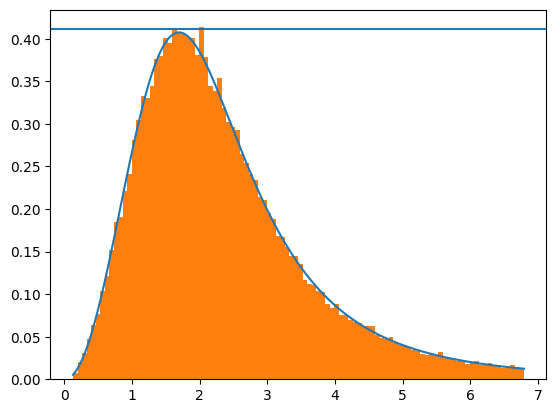

In [207]:
plt.plot(z, P_z)
_ = plt.hist(z_dist, bins=100, density=True)
plt.axhline(y_max)

In [1]:
import sys
sys.path.append("/arc/home/michilli/.local/lib/python3.8/site-packages/")

In [194]:
# Python 3.8.16
import os
import pickle
import datetime

# Numpy 1.24.2
import numpy as np
from numpy.random import default_rng
# matplotlib 3.7.1
import matplotlib.pyplot as plt
# astropy 5.2.1
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
# scipy 1.9.3
from scipy.special import j1
from scipy import optimize
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
# mpmath 1.3.0
from mpmath import gammainc
# arspy 0.4
# To be compatible with the newer numpy versions, line 102 of the installed code
# should be changed to `assert seed is None or isinstance(seed, int)`
from arspy.ars import adaptive_rejection_sampling
# This may be faster but requires the derivative 
# https://codereview.stackexchange.com/questions/174814/implementation-of-adaptive-rejection-sampling-in-cython
# It could be even faster to wrap the original C or Fortran functions with Cython



# Classes and functions

class Telescope:
    """
    Telescope parameters
    """
    parameters = {
        'dummy': {  # test parameters
            'Srec': 15 * u.Jy,
            'v0': 800 * u.MHz,
            'v1': 1600 * u.MHz,
            'D': 50 * u.m,
            'bands': [
                [800 * u.MHz, 1200 * u.MHz],
                [1200 * u.MHz, 1600 * u.MHz],
            ]
        },
        'chime': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract
            # from https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract
            'Srec': 50 / 1.38 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,            
            'Dx': 20 * u.m,
            'Dy': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
            #'D': 8.4474307*u.m
        },
        'chord': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 * u.K / 9 / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
            'bands': [
                [300 * u.MHz, 700 * u.MHz],
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
            ]
        },
        'dsa2000': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,  # Jy
            'gain': 25 * u.K / 2.5 / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
            'bands': [
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
                [1500 * u.MHz, 2000 * u.MHz],
            ]
        },
    }
    
    def __init__(self, name='chord'):
        self.name = name
        self.parameters = Telescope.parameters
        
    def get_parameters(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]
    
    def bandwidth(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1'] - self.parameters[name]['v0']
    
    def sefd(self, name = None, freq = None):
        if name is None: name = self.name
        if freq is None:
            freq = (
                self.parameters[name]['v0'] + 
                self.parameters[name]['v1']
            ) / 2
        return (
            self.parameters[name]['Srec'] + 
            34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
            self.parameters[name]['gain']
        )
    
    def v0(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v0']
    
    def v1(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1']
    
    def frequency_bands(self, name = None):
        if name is None: name = self.name
        try:
            return self.parameters[name]['bands']
        except KeyError:
            return [[
                self.parameters[name]['v0'],
                self.parameters[name]['v1']
            ]]
    
    def get_parameter(self, parameter, name = None):
        if name is None: name = self.name
        return self.parameters[name][parameter]
    
    
def get_lensed_fraction():
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, lensed_galaxies_z.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    
    # Select bins containing enough galaxies
    # Lensed population of galaxies from Collett 2018 simulations
    Pz_sim, _ = np.histogram(lensed_galaxies_z, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)
    idx = (Pz_sim > 10) & (Pz_org > 10)
        
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_bol) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        L_sim = lensed_galaxies_Mv.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            lensed_galaxies_z, 
            bins=z, 
            weights=L_sim
        )
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    lensed_fraction = lensed_fraction[idx]
    z_mean = z_mean[idx]
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)
    
    return cs, z_mean.min(), z_mean.max()


def get_distribution_redshift(
    z_max = None,
    z_min = None
):
    """Redshift distribution for a population of FRBs not evolving with redshift.
    """
    if z_max is None:
        z_max = lensed_galaxies_z.max()
    if z_min is None:
        z_min = lensed_galaxies_z.min()
        
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z)*4*np.pi*u.sr / 
        (1 + z) * (sfr(z) / sfr(0))**n_sfr
    ).to(1/u.yr).value
    #z_pdf_Mpc = lambda z: z_pdf(z).to(u.Mpc**3).value
    integral_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / integral_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max

    # Rejection sampling the distribution
    # Initially, the distribution is filled with nan
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist, z_min, z_max, integral_emission_rate


def get_distribution_dist(
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
):
    """Distribution of the distance factor.
    """
    # Fraction of lensed galaxies cataloged by Euclid vs redshift
    if simulate_lensed_frbs:
        lensed_fraction_interp, z_min, z_max = get_lensed_fraction()
    
    # Redshift distribution of FRBs in the Universe
    z_dist, z_min, z_max, integral_emission_rate = get_distribution_redshift(
        z_min = z_min,
        z_max = z_max,
    )
    
    # Only simulate lensed FRBs
    if simulate_lensed_frbs:
        P_z = lensed_fraction_interp(z_dist)
        P_random = rng.uniform(size=P_z.size)
        z_dist = z_dist[P_random <= P_z]
    
    # Distance factor
    Dl = cosmo.luminosity_distance(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(alpha + 2)
    
    return dist_factor, z_min, z_max, integral_emission_rate


def get_bandwidth_correction(
    bw_telescope,
    bw_min = 50 * u.MHz,
    loc = 400 * u.MHz,  # MHz
    scale = 400 / 2 * u.MHz,  # MHz
):
    """Assume that the bandwidth of FRBs is a normal distribution based on CHIME detections."""
    # Bandwidth distribution from a truncated normal distribution
    bw_clip = (bw_min - loc) / scale
    bw = truncnorm.rvs(
        bw_clip, 
        np.inf, 
        loc=loc, 
        scale=scale,
        size=number_of_simulated_frbs,
        random_state=rng
    ) * u.MHz
    return bw


def schechter_distribution(
    gamma,
    Echar,
    Emin
):
    """Simulated distribution of a Schechter function."""
    schechter_logpdf = lambda E: np.log((E / Echar)**gamma / Echar * np.exp(-E / Echar))
    return np.array(
        adaptive_rejection_sampling(
            logpdf = schechter_logpdf,  # Schechter function
            a = Emin,  # Lower initial condition
            b = Echar,  # Upper initial condition
            domain = (Emin, float("inf")),  # Domain of the Energy
            n_samples = number_of_simulated_frbs,
            seed = seed
        )
    )


def get_energy_minimum(
    bw,
    sefd,
    frb_bw,
    w,
    tau,
    dist_factor,
    frb_w_correction,
    frb_bw_correction,
):
    """
    Minimum FRB energy normalized to 1 GHz required to detect a burst at 
    redshift z with a signal-to-noise ratio SNr and time resolution w, 
    where rfi_band is lost due to interference.
    """
    return (
        SNr_min * np.sqrt((w + tau) / bw / 2) / frb_w_correction / frb_bw_correction * 
        sefd / np.sqrt(1 - rfi_band) * dist_factor * frb_bw
    ).min().to(u.erg)


def get_beam_response(
    telescope,
    freq_min,
    min_frb_band = 50 * u.MHz,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq_min + min_frb_band).to(u.meter, equivalencies=u.spectral())

    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = np.pi * np.sin(angle) * diameter / wavelength * np.sqrt(efficiency)
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value

    except KeyError:
        # Rectangular aperture
        size_x = telescope.get_parameter('Dx')
        size_y = telescope.get_parameter('Dy')
        # Half beam width between the first nulls
        hwfn_x = np.arcsin((wavelength / size_x).to(u.dimensionless_unscaled))
        hwfn_y = np.arcsin((wavelength / size_y).to(u.dimensionless_unscaled))
        # Random angles
        angle_x = rng.uniform(
            low=0, 
            high=hwfn_x.to(u.rad).value, 
            size=number_of_simulated_frbs
        ) * u.rad
        angle_y = rng.uniform(
            low=0, 
            high=hwfn_y.to(u.rad).value,
            size=number_of_simulated_frbs
        ) * u.rad
        # Normalized power
        power = (
            (
                np.sinc(np.sin(angle_x) * size_x / wavelength * u.rad) * 
                np.sinc(np.sin(angle_y) * size_y / wavelength * u.rad)
            )**2
        )
        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value

    return sky_fraction, power


def get_max_detected_redshift(
    snr,
    E_nu,
    bw,
    sefd,
    w,
    tau,
    w_correction,
    bw_correction,
):
    """
    Maximum redshift at which an FRB of energy E would be detected
    by a telescope of sensitivity sefd
    """
    
    dist_factor_Gpc2 = (
        1e41*u.erg/u.GHz / 8 / np.sqrt((w + tau) / bw / 2) * 
        w_correction * bw_correction / sefd * np.sqrt(1 - rfi_band)
    ).to(u.Gpc**2).max().value
    
    z_max_func = lambda z: (
        4 * np.pi * cosmo.luminosity_distance(z).to(u.Gpc).value**2 / dist_factor_Gpc2 - (1 + z)**(alpha + 2)
    )
    z_max = optimize.root(z_max_func, 1).x[0]
    return z_max
    

def get_snr(
    frb_E_nu,
    frb_dist_fact,
    alpha,
    bw_telescope,
    frb_w, 
    frb_tau,
    frb_w_correction,
    frb_bw_correction,
    beam_response, 
    sefd, 
    rfi_band
):
    return (    
        frb_E_nu / frb_dist_fact *
        np.sqrt((2 * bw_telescope) / (frb_w + frb_tau)) * 
        frb_w_correction * frb_bw_correction *
        (beam_response / sefd) *
        np.sqrt(1 - rfi_band)
    ).to(u.dimensionless_unscaled)


def convert_to_rate(
    detected_frbs,
    Emin,
    integral_emission_rate,
    sky_fraction
):
    """Convert the number of simulated FRBs to a rate.
    """
    # FRB emission rate at z=0 scaled to a minimum energy Emin
    frb_emission_rate_z0 = (
        frb_emission_rate_z0_Epivot * 
        float(gammainc(gamma + 1, (Emin / Echar).value)) / 
        float(gammainc(gamma + 1, (Epivot / Echar).value))
    )
    # FRB emission rate in the whole volume
    frb_emission_rate = frb_emission_rate_z0 * integral_emission_rate
    # Duration of the simulation in the real world
    duration_sim = number_of_simulated_frbs / frb_emission_rate
    # All-sky FRB detection rate
    frb_detected_allsky = detected_frbs / duration_sim
    # FRB rate detected by the telescope
    frb_detection_rate = frb_detected_allsky * sky_fraction
    return frb_detection_rate


def get_detection_rate(
    telescope,
    freq_low,
    freq_high,
    simulate_lensed_frbs = True,
):
    """Rate of FRB detections.
    """
    freq_mean = (freq_low + freq_high) / 2
    bw_telescope = freq_high - freq_low
    sefd = telescope.sefd(freq=freq_mean)
    
    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # Rescale to central frequency
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    # Include extragalactic scattering

    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # FRB bandwidth corrections
    frb_bw = get_bandwidth_correction(bw_telescope)
    bw_correction = np.sqrt(frb_bw / bw_telescope).clip(max=1)
    
    # FRB redshifts
    (
        frb_dist_fact,
        z_min,
        z_max,
        integral_emission_rate
    ) = get_distribution_dist(
        simulate_lensed_frbs = simulate_lensed_frbs,
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = get_energy_minimum(
        bw_telescope,
        sefd,
        frb_bw,
        frb_w,
        frb_tau,
        frb_dist_fact,
        frb_w_correction,
        frb_bw_correction,
    )
    
    # Energy distribution
    # A factor 1e40 is scaled to avoid overflows
    frb_E = schechter_distribution(
        gamma, 
        Echar.value / 1e40, 
        Emin.value / 1e40, 
    ) * 1e40 * u.erg
    # Energy spectral density distribution
    frb_E_nu = frb_E / frb_bw #/ u.GHz

    # Beam response
    sky_fraction, beam_response = get_beam_response(
        telescope,
        freq_low
    )
    
    # FRB S/N values
    frb_snr = get_snr(
        frb_E_nu,
        frb_dist_fact,
        alpha,
        bw_telescope,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_bw_correction,
        beam_response, 
        sefd, 
        rfi_band
    )
    
    # Number of detections
    idx_detected_frbs = frb_snr > SNr_min
    detected_frbs = frb_snr[idx_detected_frbs].size * observing_time
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        detected_frbs,
        Emin,
        integral_emission_rate,
        sky_fraction
    )

    # Completeness of redshift range
    z_max_detected = get_max_detected_redshift(
        frb_snr[idx_detected_frbs],
        frb_E_nu[idx_detected_frbs],
        bw_telescope,
        sefd,
        frb_w[idx_detected_frbs],
        frb_tau[idx_detected_frbs],
        frb_w_correction[idx_detected_frbs],
        frb_bw_correction[idx_detected_frbs],
    )
    if z_max < z_max_detected:
        print(f"Maximum redshift detected: {z_max_detected:.1f}")
        print(f"Maximum redshift simulated: {z_max:.1f}")
        raise RuntimeWarning("Galaxy sample not deep enough!")

    return frb_detection_rate
    

def run_simulation(
    telescope_name = 'dummy',
    simulate_lensed_frbs = True, 
):
    """ Simulate how many strongly lensed fast radio bursts (FRBs) are detected by a facility in one year.

    Parameters
    ----------
    telescope_name : str = 'chord'
        Telescope to simulate. Currently, 'chime', 'chord', and 'dsa2000' are supported.
    simulate_lensed_frbs : bool
        Simulate only lensed FRBs or the whole population.

    Returns
    -------
    float
        Rate per year.

    """
    print(f'Starting the simulation for {telescope_name}')
    print(f'{number_of_simulated_frbs} bursts will be simulated.')
    
    # Telescope parameters
    telescope = Telescope(name=telescope_name)
    
    # Search single frequency bands
    # Assumes that FRBs are intrinsically narrowband
    search_bands = telescope.frequency_bands()
    frb_detection_rate = 0 / u.yr
    
    for freq_low, freq_high in search_bands:
        frb_detection_rate += get_detection_rate(
            telescope,
            freq_low,
            freq_high,
            simulate_lensed_frbs = simulate_lensed_frbs,
        )    
    
    print(f'The detection rate is {frb_detection_rate.to(1/u.year).value:.1f} FRBs per year,')
    print(f'or 1 FRB detected every {1/(frb_detection_rate).to(1/u.year).value:.2f} years.')
    return frb_detection_rate


# Global values

# Redshift and magnitude distributions of lensed galaxies detected by Euclid
# From https://ui.adsabs.harvard.edu/abs/2015ApJ...811...20C/abstract
lensed_galaxies_z = np.loadtxt('lenses_Euclid.txt', usecols=1)  # Redshift distribution
lensed_galaxies_Mv = np.loadtxt('lenses_Euclid.txt', usecols=17) * u.M_bol # Magnitude distribution

# FRB properties
# From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
alpha = -1.39  # Spectral index
Echar = 2.38e41 * u.erg  # Characteristic energy cut-of
gamma = -1.3  # Differential power-law index
Epivot = 1e39 * u.erg  # Pivot energy
frb_emission_rate_z0_Epivot = (7.3e4 / u.Gpc**3 / u.year).to(1 / u.Mpc**3 / u.year)
n_sfr = 0.96

# Parameters of the simulation
number_of_simulated_frbs = int(1e5)  # Elements in the simulation
elements_in_distributions = int(1e4)  # 1 / resolution of continuous distributions
seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
frbs_evolve_with_luminosity = True  # FRB rate follows galaxy luminosity
zlim = None  # Limit on maximum redshift defined as [z_min, z_max]

# Assumed observational prameters
observing_time = 0.8  # Fraction of observing time
SNr_min = 8  # Minimum detectable S/N
rfi_band = 0.3  # Fraction of band affected by RFI
w_telescope = 1 * u.ms



# Run the simulation
frb_detection_rate = run_simulation(telescope_name='chime', simulate_lensed_frbs = False)

Starting the simulation for chime
100000 bursts will be simulated.


UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

In [4]:
https://web.mit.edu/urban_or_book/www/book/chapter7/7.1.3.html
https://docs.scipy.org/doc/scipy/tutorial/stats/sampling.html
https://towardsdatascience.com/rejection-sampling-with-python-d7a30cfc327b

SyntaxError: invalid syntax (2257971196.py, line 1)

In [ ]:
https://iopscience.iop.org/article/10.1086/589501/pdf  # The Schechter function is equivalent to a gamma distribution with shape parameter k = alpha + 1 and scale parameter L*
https://iopscience.iop.org/article/10.3847/2515-5172/abacb8  # one can generate samples from the BB1 distribution using a straightforward modification of a widely-used algorithm for sampling from the gamma distribution due to Ahrens & Dieter (1974). These properties make it useful for simulation studies.

In [ ]:
https://www.math.leidenuniv.nl/~gill/teaching/astro/stanSchechter.pdf

In [ ]:
# Follow-up
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

In [4]:
source_low_dec = SkyCoord(ra=0*u.deg, dec=-10*u.deg)
source_mid_dec = SkyCoord(ra=0*u.deg, dec=45*u.deg)
source_high_dec = SkyCoord(ra=0*u.deg, dec=89*u.deg)

In [5]:
gbt = EarthLocation.of_site('GBT')
gmrt = EarthLocation.of_site('GMRT')
eff = EarthLocation.of_site('Effelsberg')

90.0% of time the source can be observed


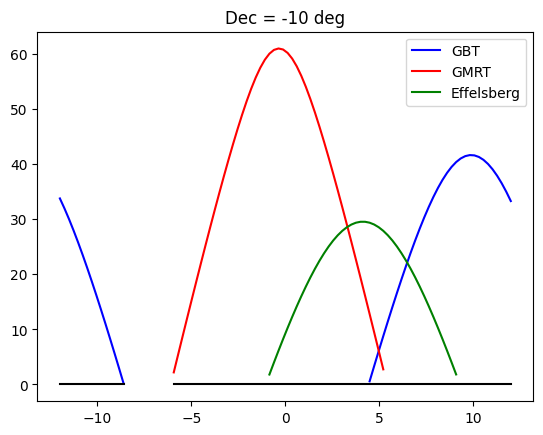

In [26]:
# Low dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_low_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_low_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_low_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = -10 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


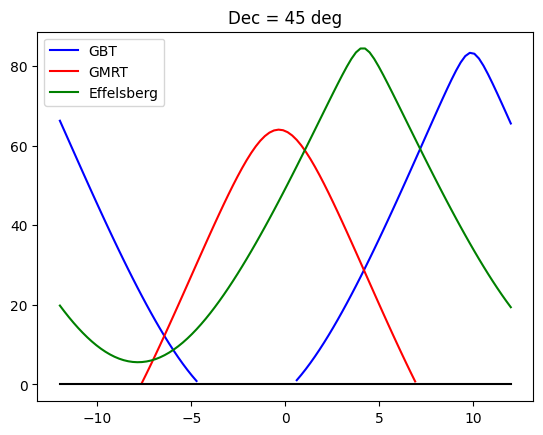

In [27]:
# Mid dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_mid_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_mid_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_mid_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 45 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


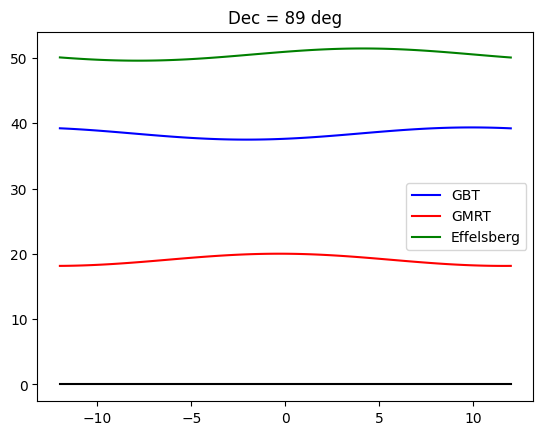

In [28]:
# High dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_high_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_high_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_high_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 89 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

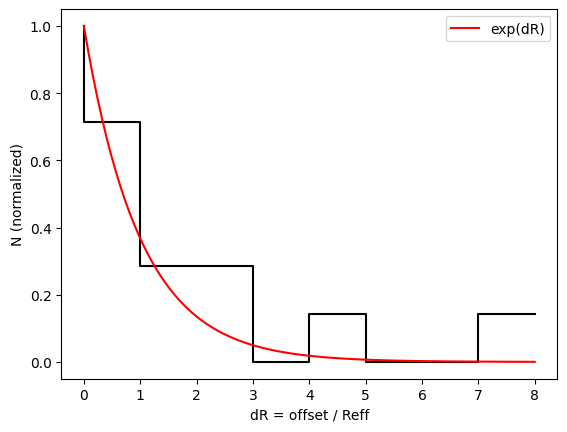

In [1125]:
# FRB radial distribution within host galaxies

#https://arxiv.org/pdf/2009.10747.pdf
#https://arxiv.org/pdf/2302.14782.pdf
#https://arxiv.org/pdf/2108.01282.pdf
#https://arxiv.org/pdf/2301.01000.pdf

# i-band and r-band
offset = np.array([0.6, 5.5, 3.4, 1.2, 2.0, 27, 6.6, 11, 3.2, 1.9, 11, 3.0, 9.87, 3.80, 10.8, 5.7, 5.9, 2.3])
reff = np.array([0.7, 3.6, 2.7, 7.2, 4.4, 3.3, 2.8, 2.1, 2.9, 3.9, 5.5, 1.6, 2.67, 6.64, 5.80, 1.78, 7.58, 2.7])

r = np.sort(offset / reff)
F = np.arange(r.size)/r.size

from scipy import stats
y_hist, bins = np.histogram(r, bins=np.arange(10))
x_hist = bins[:-1]
plt.step(x_hist, y_hist/y_hist.max(), color='k')


x = np.linspace(x_hist.min(), x_hist.max(), 100)
y = np.exp(-x)
#y = y / y.max() * 7
plt.plot(x, y, 'r-', label='exp(dR)')
plt.xlabel('dR = offset / Reff')
plt.ylabel('N (normalized)')
plt.legend()

In [1]:
import sys
sys.path.insert(0, "/arc/home/michilli/ARSpy/")

In [1]:
import sys
sys.path.append("/arc/home/michilli/.local/lib/python3.8/site-packages/")

In [2]:
import numpy as np
from arspy.ars import adaptive_rejection_sampling
import arspy
arspy

<module 'arspy' from '/arc/home/michilli/.local/lib/python3.8/site-packages/arspy/__init__.py'>

In [11]:
    gamma = -1.3
    Echar=30
    Emin=5
    """Simulated distribution of a Schechter function."""
    schechter_logpdf = lambda E: np.log((E / Echar)**gamma / Echar * np.exp(-E / Echar))
    adaptive_rejection_sampling(
        logpdf = schechter_logpdf,  # Schechter function
        a = Emin,  # Lower initial condition
        b = Echar,  # Upper initial condition
        domain = (Emin, float("inf")),  # Domain of the Energy
        n_samples = 10,
        seed=2911167007
    )

[12.861100329233185,
 9.241582899926813,
 5.879467523159431,
 13.771304112580912,
 6.769463372110595,
 28.629075515917624,
 13.878310332472786,
 41.59553148937909,
 11.339655566858509,
 6.0358931232771775]

In [335]:
z_min = 0.3
z_max = 3.

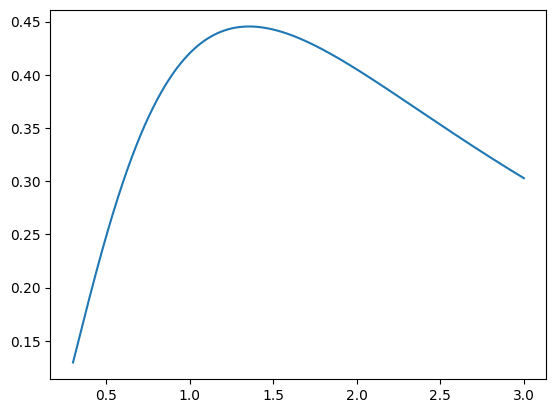

In [329]:
x = np.linspace(0.1, 1, 100000)
y = z_pdf(x)

In [330]:
integrate.simpson(y, x=x)

97657377192.34785

In [331]:
2 * ((cosmo.comoving_volume(1) / (1+1)) - (cosmo.comoving_volume(0.1) / (1+0.1)) )

<Quantity 1.63386428e+11 Mpc3>

In [349]:
    z_max = lensed_galaxies_z.max()
    z_min = lensed_galaxies_z.min()
        
    # Define z distribution PDF
    # Calculate the integrated normalization
    V = integrate.quad(z_pdf_Mpc, z_min, z_max)[0] * u.Mpc**3
    # Normalized distribution
    z_pdf_norm = lambda z: (cosmo.differential_comoving_volume(z)*4*np.pi*u.sr / (1 + z)).value

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max

    # Rejection sampling the distribution
    # Initially, the distribution is filled with nan
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x

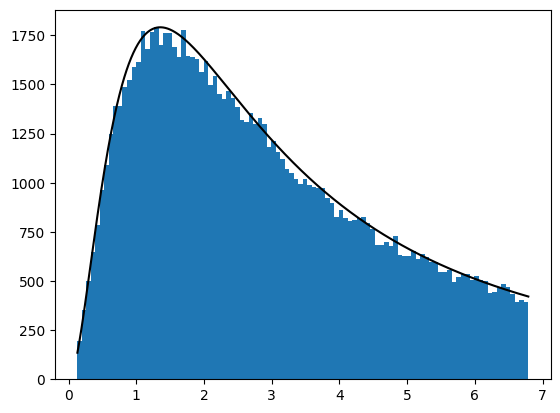

In [362]:
p, bins, _ = plt.hist(z_dist, bins=100, density=False)

x = np.linspace(z_min, z_max, 1000)
y = z_pdf_norm(x)
y = y / y.max() * p.max()
plt.plot(x, y, 'k-')

In [361]:
len(a)

3